# Lab 5: Raster Data

In this lab, we will explore raster data, which is a type of geospatial data represented by a grid of pixels. Each pixel in a raster dataset has a value that represents information, such as temperature, elevation, or land cover. Raster data is commonly used in remote sensing, geographic information systems (GIS), and various environmental and earth sciences.

We will use the following libraries:
- **NumPy**: For numerical operations.
- **Matplotlib**: For plotting and visualizing data.
- **Rasterio**: For reading and writing raster data.
- **Cartopy**: For cartographic projections and plotting.

Raster data is *gridded* data that can contain either a single band (e.g., elevation data) or multiple bands (e.g., RGB satellite imagery). All bands are contained in a single file, and each band covers the same area with the same resolution and extents. Each band consists of a 2D array, and each cell contains a numeric value.

### Key Concepts

- **Single Band**: Contains one type of data, such as elevation.
- **Multiple Bands**: Contains multiple types of data, such as RGB channels in satellite imagery.
- **Resolution**: The size of each pixel, which determines the detail of the data.
- **Extent**: The geographic area covered by the raster data.
- **Resampling**: This process changes the resolution of the raster data. Higher resolution means more detail but larger file sizes.

References: 
- [Rasterio Documentation](https://rasterio.readthedocs.io/en/stable/)
- [Open, Plot and Explore Raster Data with Python](https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/open-lidar-raster-python/)
- [Matplotlib cheatsheets](https://matplotlib.org/cheatsheets/)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show
import cartopy.crs as ccrs

%matplotlib inline

## Opening DEM using `rasterio`

Our first examples will deal with a Digital Elevation Model (DEM) that contains surface elevations of the Prince George region. This DEM was created from LiDAR data but has been *resampled* from 1 meter to 25 meters to reduce the file size (from nearly 1 TB to 4 MB!).

There are two common ways to bring raster data into Python: `rasterio` and `gdal`. In this lab, we will use `rasterio` for its simplicity and ease of use.

### rasterio
The `rasterio` library provides a simple way to open and query raster data: `rio.open('filepath')` creates an object in python:  

In [3]:
pglidar = rio.open('data/pg_lidar_dem25m_UTM10N.tif')

To check on some of the attributes of data, you can query:
- The spatial extent using the `.bounds` attribute
- The coordinate reference system with the `.crs` attribute
- The resolution with the `.res` attribute

In [4]:
print(pglidar.bounds)
print(pglidar.crs)
print(pglidar.res)

BoundingBox(left=504655.98000000004, bottom=5961275.37, right=528605.98, top=5989900.37)
EPSG:26910
(25.0, 25.0)


You can also get all the *metadata* for your raster file using the `.meta` attribute:

In [5]:
display(pglidar.meta) 

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028234663852886e+38,
 'width': 958,
 'height': 1145,
 'count': 1,
 'crs': CRS.from_epsg(26910),
 'transform': Affine(25.0, 0.0, 504655.98000000004,
        0.0, -25.0, 5989900.37)}



| Attribute   | Description                                                                 |
|-------------|-----------------------------------------------------------------------------|
| `driver`    | The format driver used to read/write the file. In this case, 'GTiff' stands for GeoTIFF. |
| `dtype`     | The data type of the raster values. 'float32' indicates 32-bit floating point numbers. |
| `nodata`    | The value used to represent missing or undefined data.                      |
| `width`     | The number of columns (pixels) in the raster.                               |
| `height`    | The number of rows (pixels) in the raster.                                  |
| `count`     | The number of bands in the raster.                                          |
| `crs`       | The Coordinate Reference System (CRS) used for the raster. This includes information about the projection and datum. |
| `transform` | The affine transformation matrix that maps pixel coordinates to geographic coordinates.|

Let's use the built-in rasterio function `rio.plot.show()`to take a preliminary look at the dataset (this is analogous to the `geopandas.plot()` function): 

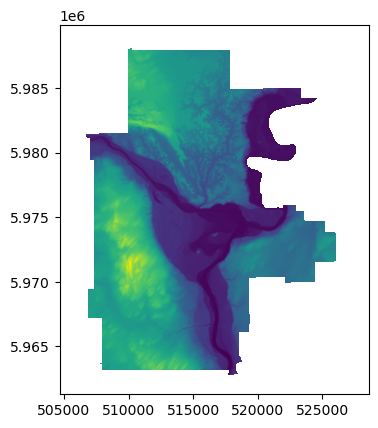

<Axes: >

In [6]:
rio.plot.show(pglidar)

## Reading the raster data to an array
So, we have opened a raster dataset, checked some attributes, and made a simple map. To assign the data in the raster to a NumPy array, we use the `read` function on the open raster dataset.

In [7]:
data = pglidar.read(1)  
# The '1' indicates that we are reading the first band. 
# If the raster had multiple bands, you could read them by changing the number.
print(data.shape)
print(type(data))

(1145, 958)
<class 'numpy.ndarray'>


Now that the data are stored in an array we can analyse and visualize with matplotlib:

-3.4028235e+38
<class 'numpy.float32'>


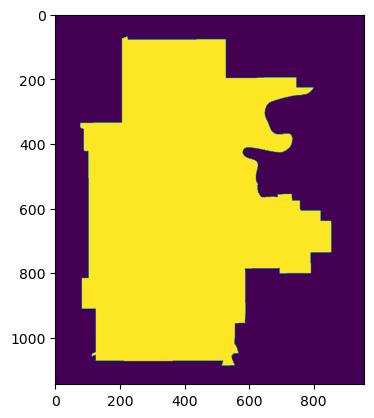

In [8]:
# this is the value in position [0,0]
print(data[0,0])          

# get data type
print(type(data[0,0]))

# use matplotlib imshow
plt.imshow(data)   

Notice two things here: 
* `plt.imshow` *(MatPlotLib)* shows all the data: even the null values of -3.4028235e+38. But the `rasterio.plot.show` treated the null values as no data, and masks them out. 
* The spatial extent is now missing, and the x and y axes are just column and row number

We have looked previously at using histograms to examine the distribution of our data, and we can also calculate statistics for the data. Let's do so again, using the `ravel` function to flatten the data, and a quick filter to remove data where the elevation is less than 0: 

Max elevation: 885.100
Min elevation: 558.760
Mean elevation: 681.325
Median elevation: 682.977


Text(0, 0.5, 'Count')

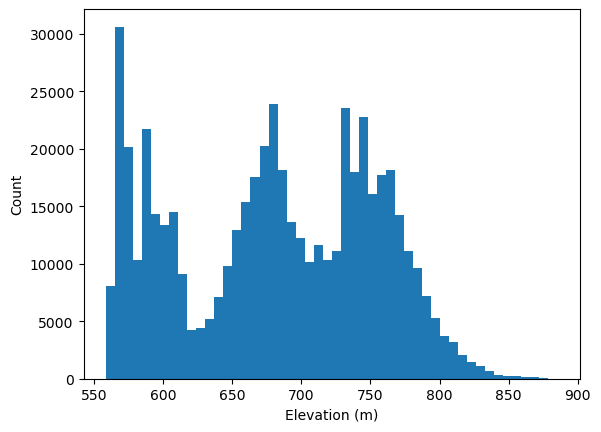

In [9]:
# flatten the data to a 1D array
data_ravel = np.ravel(data)

# find where elevation is less than zero
a = data_ravel < 0

# calculate statistics from the flattened and filtered array (valid pixels only):
print(f'Max elevation: {data_ravel[~a].max():.3f}')
print(f'Min elevation: {data_ravel[~a].min():.3f}')
print(f'Mean elevation: {data_ravel[~a].mean():.3f}')
print(f'Median elevation: {np.median(data_ravel[~a]):.3f}')

# histogram of the valid data:
plt.hist(data_ravel[~a], 50)
plt.xlabel('Elevation (m)')
plt.ylabel('Count')

**Exercise 1:** There are 3 peaks in the histogram around 570, 680, and 740 m. Thinking of the general topography of Prince George, what do these peaks represent? Answer in a `Markdown` cell.

Code breakdown:

1. **Flatten the data to a 1D array**:
    ```python
    data_ravel = np.ravel(data)
    ```
    - `np.ravel(data)`: This function flattens the 2D array `data` into a 1D array. This is useful for performing operations that require a 1D array, such as creating a histogram.

2. **Find where elevation is less than zero**:
    ```python
    a = data_ravel < 0
    ```
    - `data_ravel < 0`: This creates a boolean array `a` where each element is `True` if the corresponding element in `data_ravel` is less than zero, and `False` otherwise. This helps in identifying invalid or unwanted data points (e.g., negative elevations).

3. **Histogram of the valid data**:
    ```python
    plt.hist(data_ravel[~a], 50)
    ```
    - `data_ravel[~a]`: This selects only the elements in `data_ravel` where `a` is `False` (i.e., where the elevation is not less than zero). The `~` operator negates the boolean array `a`.
    - `plt.hist(data_ravel[~a], 50)`: This creates a histogram of the valid elevation data with 50 bins.

### `rasterio` Plotting Tricks
Currently, there is no way to add a colorbar directly throught the `rasterio.plot.show` command. So we will fake it by using `imshow` to create the axes and plot the data first, and then use `show` to add the data to the same axes: 

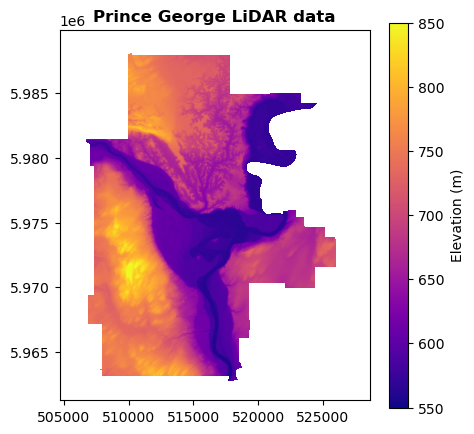

In [10]:
# open the raster file
pglidar = rio.open('data/pg_lidar_dem25m_UTM10N.tif')
data = pglidar.read(1) # The '1' indicates that we are reading the first band. 

# create figure and axes with the subplots command
fig, ax = plt.subplots(figsize=(5, 5))

# use imshow so that we have something to map the colorbar to
image_hidden = ax.imshow(data, cmap='plasma', vmin=550, vmax=850)

# plot the raster data using rio.plot.show
image = rio.plot.show(pglidar, ax = ax, cmap='plasma', vmin=550, vmax=850, title='Prince George LiDAR data')

# add the colorbar to the figure
cb = plt.colorbar(image_hidden)
cb.set_label('Elevation (m)')

*Code breakdown:*


* **Data Range Consistency**: Both the `imshow` and `rio.plot.show` functions use the same data range, set with `vmin` and `vmax`. This ensures that the color mapping is consistent across both plots.
* **Colorbar Creation**: The colorbar is created using the hidden image from `imshow`. This is necessary because `rasterio.plot.show` does not directly support adding a colorbar.
* **Axes Specification**: The `rio.plot.show` function specifies the axes created by `imshow`. This ensures that the raster data is plotted on the same axes.
* **Coordinate Reference System (CRS)**: The axes are in UTM Zone 10 (UTM10) because `rasterio` recognizes the CRS of the data. This means that the plot is correctly georeferenced.

## Combining `rasterio` and `cartopy`
We can use `plt.imshow` to get a quick look at the data, but there is no geospatial information attached: it's just an array of numbers. We will use `cartopy` here to map our data array, but first we need to get the extent of the dataset we are working with (we will work with the projected data set). 

To get the extents for plotting, use the `rio.plot.plotting_extent()` function from `rasterio`:

In [11]:
img_extent = (rio.plot.plotting_extent(pglidar))

print(img_extent)

(504655.98000000004, 528605.98, 5961275.37, 5989900.37)


Now we will do the following:
1. Extract the data to an array
2. Set up your cartopy map
3. Use `imshow` to display the data
4. Set the transform and set the extent. 

Reminder: What `transform` Does

The `transform` parameter specifies the coordinate reference system (CRS) of the image data. By setting `transform=ccrs.UTM(10)`, you are telling `imshow` that the data is in UTM Zone 10 coordinates. This ensures that the image is correctly georeferenced and aligned with the map projection specified for the axes. Without this, the image might not be displayed in the correct location on the map.

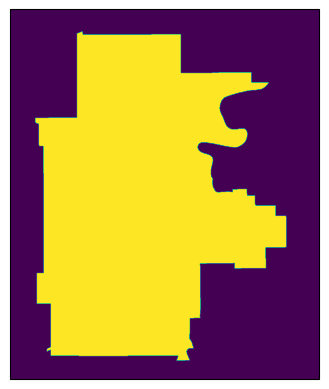

In [12]:
data = pglidar.read(1)
plt.figure()
ax = plt.axes(projection=ccrs.UTM(10))
ax.imshow(data, extent=img_extent, transform=ccrs.UTM(10))

To make our figure look better, we first need to mask out the null values. Since we already know what constitutes a null value (in this case, any value less than zero, which doesn’t make sense for elevation data), we can use `NumPy’s` masked array functions `np.ma`. In particular, the `np.ma.masked_less()` function lets us mask all values in our array that are below a specified threshold.

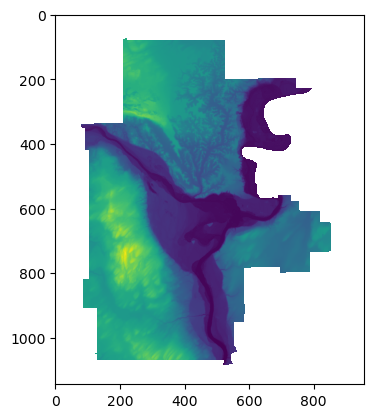

In [13]:
# Mask all values in 'data' that are less than 0.
data_ma = np.ma.masked_less(data, 0)

# Display the masked data using imshow.
plt.imshow(data_ma)

After masking, it’s helpful to inspect the masked array. When you print the array, you’ll notice that it now consists of two parts: the actual data and an associated mask (a boolean array) that indicates which values are hidden.

In [14]:
print(data_ma.shape) # Array dimensions
data_ma  # This will display both the data and the boolean mask.

(1145, 958)


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

Now we’re ready to create a more polished plot using `Cartopy`. We’ll set up the plot with a specified coordinate reference system (CRS) and define the geospatial extent of our data.

Tips:
- Make sure your geospatial extent (`img_extent`) is in the same CRS as your plot axes.
- When working with `Cartopy`, it is helpful to remove gridlines and adjust their labels for a cleaner look.

Now lets plot the array using `imshow` on `cartopy` axes, remove gridlines, and include a colorbar for reference.

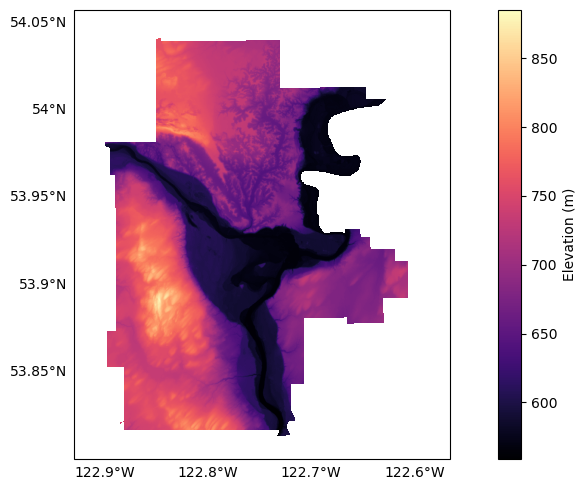

In [15]:
# Create a new figure with a specified size.
plt.figure(figsize=(10, 5))

# Define the projection using UTM zone 10 (adjust this as needed for your data).
proj = ccrs.UTM(10)

# Set up the axes with the defined projection.
ax = plt.axes(projection=proj)

# Use imshow to display the masked data.
plt.imshow(data_ma, extent=img_extent, cmap='magma')

# Create gridline object (gl) and set properties.
gl = ax.gridlines(draw_labels=True)
gl.xlines = False  # Turn off vertical grid lines.
gl.ylines = False  # Turn off horizontal grid lines.
gl.top_labels = False  # Hide labels on the top edge.
gl.right_labels = False  # Hide labels on the right edge.

# Create a colorbar and label it.
cb = plt.colorbar()
cb.set_label('Elevation (m)')

# Optionally, adjust the layout for a cleaner presentation.
plt.tight_layout()

## Combining Multiple Raster Datasets 
When working with elevation data, it is often useful to overlay a **hillshade** image. A hillshade is a synthetic image that simulates the effect of sunlight on terrain by assuming a specific sun position. In this lab, the hillshade image (generated from the Prince George LiDAR dataset) is provided in your data folder.

First, open the hillshade dataset using Rasterio and display it with a grayscale colormap.

*Tip: Verify the file path and check the CRS to ensure it matches your other datasets.*

EPSG:26910


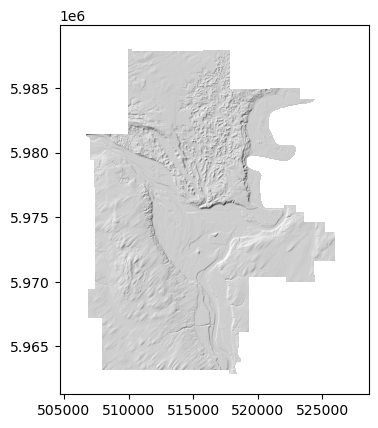

<Axes: >

In [16]:
# Assign the hillshade dataset to the variable 'hs'
hs = rio.open('data/pg_lidar_dem25m_UTM10N_HS.tif')

# Check the CRS of the hillshade data
print(hs.crs)

# Display the hillshade image using Rasterio's plotting function
rio.plot.show(hs, cmap='Greys_r')

Next, read the hillshade data into a Python array and inspect its values and shape. Plot a histogram to examine the distribution of pixel values.

0
Array shape: (1145, 958)


Text(0.5, 1.0, 'Histogram of Hillshade Data')

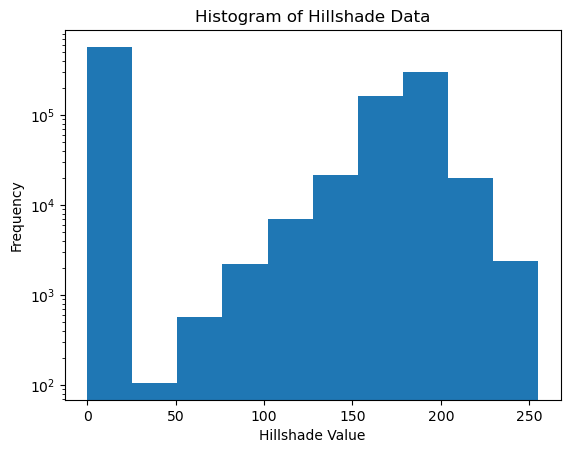

In [17]:
# Read the first band of the hillshade data into an array
hs_arr = hs.read(1)

# Print the first element and the shape of the array
print(hs_arr[0, 0])
print(f'Array shape: {hs_arr.shape}')

# Plot a histogram of the hillshade values
plt.hist(np.ravel(hs_arr), log=True)
plt.xlabel('Hillshade Value')
plt.ylabel('Frequency')
plt.title('Histogram of Hillshade Data')

Because hillshade values of zero may not be useful for visualization. Similar to `np.ma.masked_less()` which masks all pixels less than a certain value, we will mask them using the `np.ma.masked_equal()` function. This function creates a masked array where all pixels equal to zero are hidden.

In [18]:
# Mask all pixels in hs_arr that are equal to 0
hs_ma = np.ma.masked_equal(hs_arr, 0)

# Display the masked array to inspect the masked values
hs_ma

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint8)

Now, we will combine our elevation data with the hillshade. The elevation data (already masked to remove null values) will be displayed using a colormap, while the hillshade is overlaid with some transparency to enhance terrain detail. Both layers will be plotted using `Cartopy` and `Matplotlib`.

*Tip: Overlaying hillshade on elevation data can dramatically improve the readability of terrain features. Adjusting the transparency (alpha) helps blend the two layers effectively.*

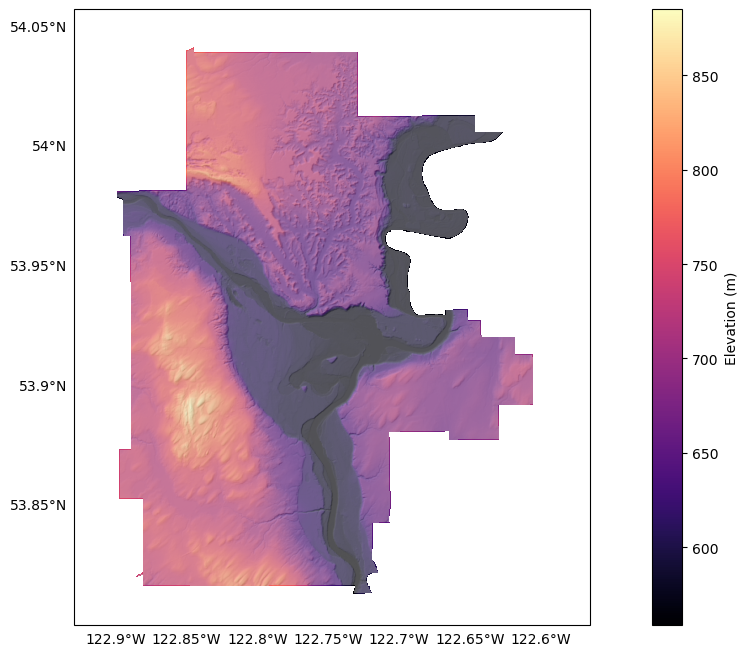

In [19]:
plt.figure(figsize=(16, 8))

# Set up the map axes using UTM Zone 10 CRS (proj should be defined beforehand)
ax = plt.axes(projection=proj)

# Plot the elevation data (data_ma) with its geospatial extent and a magma colormap
d1 = plt.imshow(data_ma, extent=img_extent, cmap='magma')

# Overlay the hillshade data with a grayscale colormap and transparency
plt.imshow(hs_ma, extent=img_extent, cmap='Greys_r', alpha=0.4)

# Add gridlines and customize their appearance
gl = ax.gridlines(draw_labels=True)
gl.xlines = False  # Remove vertical grid lines
gl.ylines = False  # Remove horizontal grid lines
gl.top_labels = False  # Hide top labels
gl.right_labels = False  # Hide right labels

# Add a colorbar for the elevation data and label it
cb = plt.colorbar(d1)
cb.set_label('Elevation (m)')

To explore detailed terrain features, you can zoom in on a subset of your data using `Cartopy's` `ax.set_extent()` function. This function requires you to specify the new extents in the same CRS as your axes.

In [20]:
# Define new plotting extents in UTM Zone 10 (subset of the full extent (img_extent))
print(img_extent) # Full extent
img_extent2 = (508000, 520000, 5969000, 5979000) # Subset extent

(504655.98000000004, 528605.98, 5961275.37, 5989900.37)


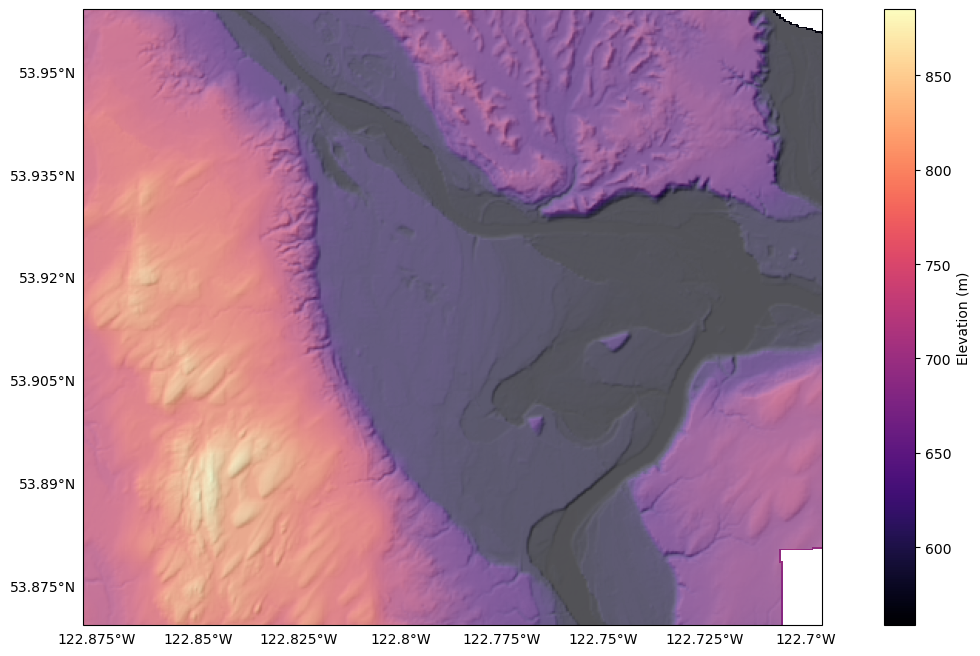

In [21]:
plt.figure(figsize=(16, 8))

# Set up the axes using the same UTM Zone 10 CRS
ax = plt.axes(projection=proj)

# Zoom in to the specified extent using set_extent()
ax.set_extent(img_extent2, crs=proj)

# Plot the elevation data with its original extent
d1 = plt.imshow(data_ma, extent=img_extent, cmap='magma')

# Overlay the hillshade data with transparency
plt.imshow(hs_ma, extent=img_extent, cmap='Greys_r', alpha=0.4)

# Customize gridlines as before
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False

# Add a colorbar for the elevation data
cb = plt.colorbar(d1)
cb.set_label('Elevation (m)')

**Exercise 2:** Change the `vmin` and `vmax` parameters in your `imshow` command for the elevation data. Experiment with these values to better highlight the subtle, gradual elevation changes in the Prince George "bowl" (also known as the Fraser River floodplain). Adjusting these parameters can help emphasize small differences in elevation that might otherwise be overlooked.

## Raster Analysis

At the end of the last Ice Age, a large glacial lake formed over the Prince George area, with an estimated surface elevation of 736 m asl ([Miller et al. 2021](https://www.sciencedirect.com/science/article/pii/S0169555X21003068)). 

In this section, we will both visualize what this lake might have looked like and calculate the total water volume contained in the “bowl” (i.e., the basin defined by the extent of your LiDAR map).

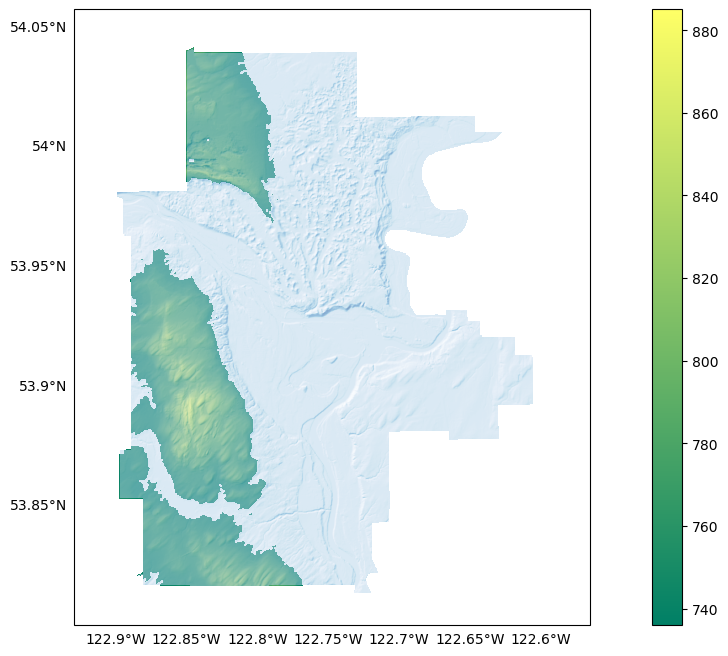

In [22]:
plt.figure(figsize=(16, 8))

# Mask all pixels that are less than 736 so we only plot elevations "above water".
data_water = np.ma.masked_less(data, 736)

# Set up the axes using the same UTM Zone 10 CRS
proj = ccrs.UTM(zone=10)
ax = plt.axes(projection=proj)

# Reset img_extent to the full extent of the data
img_extent = (rio.plot.plotting_extent(pglidar))

# Plot the elevation data with its original extent
d1 = plt.imshow(data_water, extent=img_extent, cmap='summer')

# Overlay the hillshade data with transparency
plt.imshow(hs_ma, extent=img_extent, cmap='Blues_r', alpha=0.5)

# Customize gridlines
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False

# Add a colorbar for the elevation data
cb = plt.colorbar(d1)

We now calculate the volume of water that would have occupied the basin if the lake’s surface were at 736 m. For each pixel, if its elevation is below 736 m, the water depth is $736 − elevation$; otherwise, it’s 0. Multiplying the water depth (in meters) by the area of a pixel (in square meters) yields a volume in cubic meters.

In [23]:
# Constants
SURFACE_ELEVATION = 736  # Surface elevation of the glacial lake in meters
PIXEL_AREA = 25 ** 2  # Area of each pixel = Pixel resolution (25x25m) in square meters

In [24]:
# Calculate water depth: if a pixel's elevation is below 736 m, water depth = (736 - elevation); else 0.
## (i.e. how deep the water would be above that pixel)
water_depth = np.maximum(0, SURFACE_ELEVATION - data_ma)
# Calculate the volume of terrain above the lake surface (used to compute the total basin capacity)
## (i.e. elevation above the lake surface)
above_water = np.maximum(0, data_ma - SURFACE_ELEVATION)

# Sum the water depth over all pixels (ignoring NaNs) and multiply by the pixel area to get total water volume in cubic meters.
water_volume = np.nansum(water_depth) * PIXEL_AREA
above_water_volume = np.nansum(above_water) * PIXEL_AREA

# Convert volumes to cubic kilometers.
water_volume_km3 = water_volume / 1e9
total_basin_volume_km3 = (water_volume + above_water_volume) / 1e9

print(f"Total basin capacity: {total_basin_volume_km3:.2f} cubic kilometers")
print(f"Volume of water: {water_volume_km3:.2f} cubic kilometers")

Total basin capacity: 23.76 cubic kilometers
Volume of water: 20.88 cubic kilometers


*Tips and code breakdown:*

- **Use `np.maximum` for pixel-wise operations:** This function efficiently computes the depth at each pixel. Read the documentation (`np.maximum?`) for more information.

- **Handle missing data with `np.nansum`:** If your elevation data contains NaNs (from masked or no-data regions), `np.nansum` will ignore them.

- `water_volume = np.nansum(water_depth) * PIXEL_AREA` 
    - Multiplying the total water depth (in meters) by PIXEL_AREA (in m²) converts the depth-sum into a volume (in m³).
    - Why? Each pixel contributes a volume equal to its water depth (in m) multiplied by its area (in m²). Summing over all pixels gives the total volume.

- **Double-check units:** Make sure your pixel resolution and elevation values are in the same units (meters here), so that the volume calculation is correct.

## Working with Loops and Matrices

In this section, you will learn two skills:

1. **Simulating Random Events Using For Loops**
- Learn how to create an empty list and fill it using a loop and Python’s random sampling functions.

2. **Creating and Filling Matrices with Nested Loops**
- Learn how to create an empty matrix (as a list of lists) and then fill it using nested loops.

### Simulating Dice Rolls

A common introductory task for using loops is to simulate random events.

In this example, we simulate 20 dice rolls using a for loop and the `random.randint()` function. Each outcome (a number between 1 and 6) is added to an initially empty list using the `.append()` method.

In [25]:
import random

# Simulate 20 dice rolls and store the outcomes in a list using a list comprehension
dice_rolls = [random.randint(1, 6) for _ in range(20)]

# Display the outcomes
print("Dice roll outcomes:")
print(dice_rolls)

Dice roll outcomes:
[4, 4, 1, 2, 4, 1, 1, 6, 3, 3, 3, 3, 4, 6, 1, 1, 1, 2, 3, 6]


Code breakdown:

`for _ in range(20):`

- `range(20)` generates a sequence of numbers from 0 to 19, meaning the loop will run 20 times.
- `for _ in ...` is a loop that iterates 20 times. If you don't use `i` in the loop body, it's common practice to use `_` instead to indicate that the variable is intentionally ignored.

`random.randint(1, 6)`

- `random.randint(1, 6)` calls the `randint` function from the `random` module. It returns a random integer between 1 and 6 (inclusive), simulating the roll of a six-sided die.

The result of this loop and function call is stored in the variable `dice_rolls`.

**Exercise 3:** Modify the code above to define (`def`) a function called `roll_dice` where the input rolls `n` number of dice.

### Creating and Filling a Matrix with Nested Loops

Sometimes you need to build a matrix (a grid of numbers) where each element is determined by its row and column positions. Understanding how to manipulate matrices using Python prepares you to work with many types of geospatial data. The skills introduced here (using loops, pre-allocating data structures, and filling matrices) are directly applicable to processing DEMs, remote sensing imagery, and performing spatial transformations.

In the following example, we create a matrix and fill it using nested loops:

*Tip: Remember that Python lists are 0-indexed. When working with nested loops, think about how you want to use the row index (`i`) and the column index (`j`) to compute each matrix element.*

In [26]:
# Define the dimensions of the matrix
n = 4

# Create an empty 4x4 matrix using list comprehension
matrix_example = [[0 for _ in range(n)] for _ in range(n)]
#print(matrix_example)

# Fill the matrix using nested loops.
# In this example, we use the sum of the row and column indices as the element's value.
for i in range(n):
    #print(i)
    for j in range(n):
        #print(j)
        matrix_example[i][j] = i + j  # You can change this logic for different patterns
        #print(matrix_example)

Code breakdown:

`matrix_example = [[0 for _ in range(n)] for _ in range(n)]`
- This line initializes a `n`x`n` matrix filled with zeros.
- **Inner List Comprehension:** `[0 for _ in range(n)]`
    - Creates a list of n zeros. The underscore (`_`) is used as a placeholder since the variable isn't needed.

- **Outer List Comprehension:** `[... for _ in range(n)]`
    - Repeats the inner list `n` times to form a list of lists (a matrix).
```
for i in range(n):
    for j in range(n):
        matrix_example[i][j] = i + j  # You can change this logic for different patterns
```
- **Outer Loop**: `for i in range(n):`
    - Iterates over each row index `i` from 0 to 3.

- **Inner Loop**: `for j in range(n):`
    - Iterates over each column index `j` from 0 to 3.

- **Assignment**: `matrix_example[i][j] = i + j`
    - Sets the element at row `i` and column `j` to the sum of `i` and `j`.
    - This results in a matrix where each element is the sum of its row and column indices.

In [27]:
# Display the resulting matrix
print("Matrix filled with the sum of indices:")
for row in matrix_example:
    print(row)

Matrix filled with the sum of indices:
[0, 1, 2, 3]
[1, 2, 3, 4]
[2, 3, 4, 5]
[3, 4, 5, 6]


Each element `(i, j)` in the matrix contains the value `i + j`.

# End of Lab 5

Extra for fun, simulate drawing cards form a deck. Mess around with printing various loops, altering the code, etc. to understand how it works.

In [28]:
def create_deck():
    """Create a standard deck of 52 cards."""
    suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
    ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'Jack', 'Queen', 'King', 'Ace']
    deck = []
    for suit in suits:
        #print(suits)
        for rank in ranks:
            #print(ranks)
            deck.append(f'{rank} of {suit}')
    deck.append('Joker')
    return deck

def draw_cards(deck, n):
    """Draw n cards from the deck."""
    if n > len(deck):
        raise ValueError("Cannot draw more cards than are in the deck")
    return random.sample(deck, n)

# Create a deck of cards
deck = create_deck()

# Number of cards to draw
n = 4

# Draw n cards from the deck
drawn_cards = draw_cards(deck, n)

# Display the drawn cards
print(f'{n} cards:')
for card in drawn_cards:
    print(card)

4 cards:
8 of Diamonds
9 of Spades
2 of Diamonds
King of Hearts
